In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import os
import re
import json
from tqdm import tqdm

In [28]:
# seaborn settings
sns.set_theme(style="whitegrid")
palette = {"node 1":"green", "node 2": "blue", "kube controller": "black"}
sns.set_theme(style="ticks")

In [29]:
# globals
files = []
files_csv = []
similar_files_csv = []

In [30]:
# pandas utils
def pp_node_names(row):
    if row["node"] == "cloud0_adaim":
        return "node 1"
    elif row["node"] == "cloud1_adaim":
        return "node 2"
    else:
        return "kube controller"

In [39]:
# utils
def read_files_merge_into_df(file_list):
    file_dir = 'energy_data_csv'
    tmp_df_list = []
    for file in file_list:
        file = file_dir + '/' + file
        df = pd.read_csv(file)
        tmp_df_list.append(df)
    return pd.concat(tmp_df_list)
        

def sort_key_function(file) -> str:
    tmp = file.split("-")
    tmp.pop(0)
    return '-'.join(tmp)

def get_similar_files_list(query):
    # returns the similar file list according to query
    for i in range(len(similar_files_csv)):
        if query in similar_files_csv[i][0]:
            return similar_files_csv[i]

def convert_file_to_csv_and_save(file):
    node = file.split('-')[0]
    new_csv_file = 'energy_data_csv/' + file.replace('json', 'csv')
    file = 'energy_data_1000_req/' + file
    
    with open(file) as f:
        data = f.read()

    tmp_sep = re.split(r'(?={"host":)', data)
    # pop first and last as it contain json errors
    tmp_sep.pop(0)
    tmp_sep.pop()

    #json_str = tmp_sep[0]
    #print(json.dumps(json.loads(json_str), indent=2))
    
    tmp_dict = {
        'id_':[],
        'timestamp':[],
        'consumption':[],
        'node':[]
    }
    for i in range(len(tmp_sep)):
        json_obj = json.loads(tmp_sep[i])
        timestamp = json_obj["host"]["timestamp"]
        consumption = json_obj["host"]["consumption"]
        
        tmp_dict["id_"].append(i)
        tmp_dict["timestamp"].append(timestamp)
        tmp_dict["consumption"].append(consumption)
        tmp_dict["node"].append(node)

    df = pd.DataFrame(tmp_dict)
    df.to_csv(new_csv_file, index=False)

In [32]:
# sort files
files = os.listdir("energy_data_1000_req")
files.sort(key=sort_key_function)

In [33]:
# convert file to csv
for i in tqdm(range(len(files))):
    file = files[i]
    convert_file_to_csv_and_save(file)

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 35.88it/s]


In [35]:
# sort csv files after creation
files_csv = os.listdir("energy_data_csv")
files_csv.sort(key=sort_key_function)
# pop ipynb_checkpoints

In [36]:
# file separation
for i in range(2,len(files_csv),3):
    similar_files_csv.append([files_csv[i], files_csv[i-1], files_csv[i-2]])

In [37]:
similar_files_csv

[['cloud1_adaim-default-hotelReservation-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud_controller_adaim-default-hotelReservation-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud0_adaim-default-hotelReservation-1000reqs-20mdur-50tr-defaultst-report.csv'],
 ['cloud0_adaim-default-mediaMicroservices-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud_controller_adaim-default-mediaMicroservices-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud1_adaim-default-mediaMicroservices-1000reqs-20mdur-50tr-defaultst-report.csv'],
 ['cloud_controller_adaim-default-socialNetwork-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud0_adaim-default-socialNetwork-1000reqs-20mdur-50tr-defaultst-report.csv',
  'cloud1_adaim-default-socialNetwork-1000reqs-20mdur-50tr-defaultst-report.csv'],
 ['cloud1_adaim-descheduler-hotelReservation-1000reqs-20mdur-50tr-lowNodeUtilizationst-report.csv',
  'cloud0_adaim-descheduler-hotelReservation-1000reqs-20mdur-50tr-lowNodeUtilizationst-report.csv',
  'cl

In [40]:
# normalize the consumption column
scaler = MinMaxScaler()

# read all files into one df
df = read_files_merge_into_df(files_csv)
scaler.fit_transform(df[["consumption"]])

array([[0.32673117],
       [0.44796884],
       [0.46835595],
       ...,
       [0.01857248],
       [0.02697133],
       [0.02248253]])

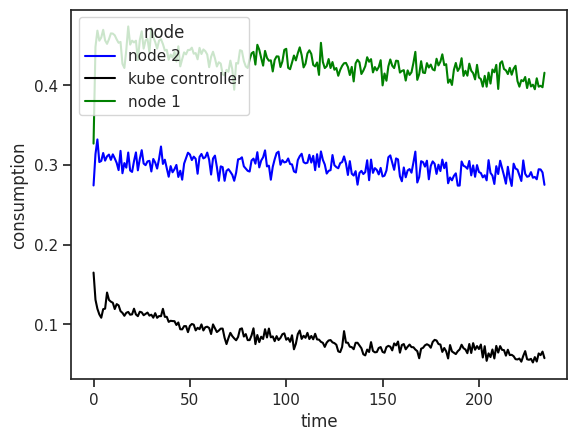

In [47]:
# chart 1000 reqs hotelReservation default
plot_files = get_similar_files_list('default-hotelReservation-1000reqs')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/hotel-reservation-default", bbox_inches='tight')

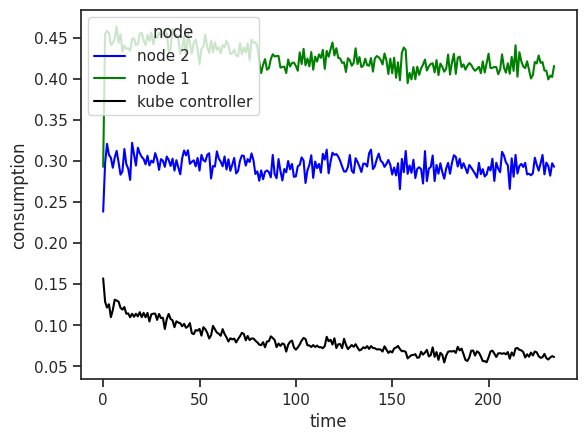

In [48]:
# chart 1000 reqs hotelReservation lowNode utilization
plot_files = get_similar_files_list('descheduler-hotelReservation-1000reqs')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/hotel-reservation-lowNodeUtilization", bbox_inches='tight')

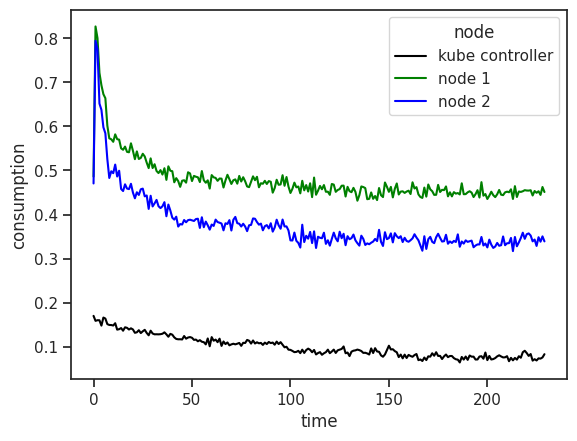

In [49]:
# chart 1000 reqs hotelReservation poseidon
plot_files = get_similar_files_list('poseidon-hotelReservation-1000reqs')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/hotel-reservation-poseidon", bbox_inches='tight')

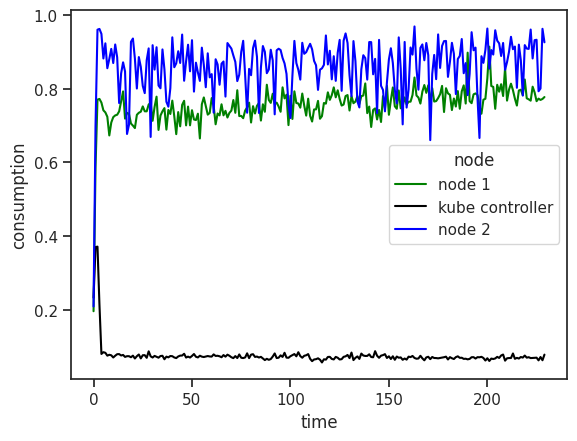

In [50]:
# chart 1000 reqs media microservices default
plot_files = get_similar_files_list('default-mediaMicroservices-1000reqs')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/media-microservices-default", bbox_inches='tight')

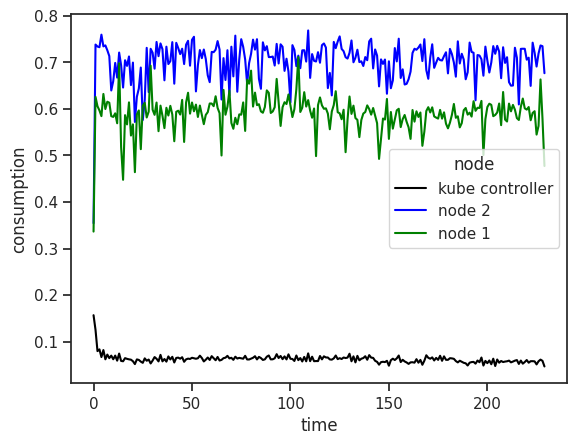

In [52]:
# chart 1000 reqs media microservices lowNodeUtilization
plot_files = get_similar_files_list('mediaMicroservices-1000reqs-20mdur-50tr-throttled80st')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/media-microservices-80throttled", bbox_inches='tight')

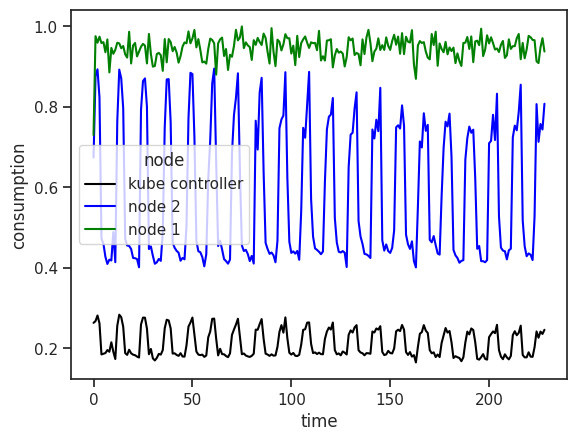

In [51]:
# chart 1000 reqs media microservices poseidon
plot_files = get_similar_files_list('poseidon-mediaMicroservices-1000reqs')
df = read_files_merge_into_df(plot_files)

# convert node names
df["node_pp"] = df.apply(pp_node_names, axis=1)

# normalize the consumption column
df["consumption_normalized"] = scaler.transform(df[["consumption"]])

# display consumption for each node
sns_plot = sns.lineplot(data=df,x="id_",y="consumption_normalized",hue="node_pp", palette=palette)
sns_plot.set(xlabel="time", ylabel="consumption")
sns_plot.legend(title="node")
plt.show()

# save the figure
sns_plot.figure.savefig("graph_data/media-microservices-poseidon", bbox_inches='tight')

In [63]:
# difference in consumption between hotel reservation
plot_files = get_similar_files_list('poseidon-hotelReservation-1000reqs-20mdur-50tr-defaultst')
df_media_pos = read_files_merge_into_df(plot_files)
plot_files = get_similar_files_list('default-hotelReservation-1000reqs')
df_media_def = read_files_merge_into_df(plot_files)

pos_sum = df_media_pos["consumption"].sum()
def_sum = df_media_def["consumption"].sum()
print(((pos_sum - def_sum )/def_sum) * 100)

13.614913868887285


In [62]:
# difference in consumption between media microservices
plot_files = get_similar_files_list('poseidon-mediaMicroservices-1000reqs-20mdur-50tr-defaultst')
df_media_pos = read_files_merge_into_df(plot_files)
plot_files = get_similar_files_list('default-mediaMicroservices-1000reqs')
df_media_def = read_files_merge_into_df(plot_files)

pos_sum = df_media_pos["consumption"].sum()
def_sum = df_media_def["consumption"].sum()
print(((pos_sum - def_sum )/def_sum) * 100)

2.031808649562361


In [69]:
# difference between poseidon 80% and pos 100%
plot_files = get_similar_files_list('poseidon-mediaMicroservices-1000reqs-20mdur-50tr-defaultst')
df_media_pos = read_files_merge_into_df(plot_files)
plot_files = get_similar_files_list('poseidon-mediaMicroservices-1000reqs-20mdur-50tr-throttled')
df_media_def = read_files_merge_into_df(plot_files)

pos_sum = df_media_pos["consumption"].sum()
def_sum = df_media_def["consumption"].sum()
print(((pos_sum - def_sum )/def_sum) * 100)

26.1102001886831


In [68]:
# difference between poseidon 80% nad default
plot_files = get_similar_files_list('default-mediaMicroservices-1000reqs')
df_media_pos = read_files_merge_into_df(plot_files)
plot_files = get_similar_files_list('poseidon-mediaMicroservices-1000reqs-20mdur-50tr-throttled')
df_media_def = read_files_merge_into_df(plot_files)

pos_sum = df_media_pos["consumption"].sum()
def_sum = df_media_def["consumption"].sum()
print(((pos_sum - def_sum )/def_sum) * 100)

23.598906907374527
